In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import tensorflow as tf
from PIL import Image, ImageDraw

### Task 1: Plot the ground truth bounding boxes over the image

In [2]:
train_dataset = pd.read_csv("./kangaroodataset/train_labels.csv")
train_dataset

,filename,width,height,class,xmin,ymin,xmax,ymax,source
0,kangaroo-623.jpg,1000,667,kangaroo,26,165,196,629,https://animals.sandiegozoo.org/sites/default/...
1,kangaroo-456.jpg,1200,720,kangaroo,741,1,1058,720,https://cdn2.wanderlust.co.uk/media/3741/artic...
2,kangaroo-25.jpg,1900,1289,kangaroo,1020,831,1225,1114,https://www.nationalgeographic.com/content/dam...
3,kangaroo-434.jpg,805,604,kangaroo,468,4,805,604,https://i.insider.com/5aeb3e57bd96714d008b45d6...
4,kangaroo-596.jpg,679,929,kangaroo,1,683,161,925,https://images-na.ssl-images-amazon.com/images...
...,...,...,...,...,...,...,...,...,...
417,kangaroo-79.jpg,1200,881,kangaroo,562,365,1051,793,https://thumbor.forbes.com/thumbor/fit-in/1200...
418,kangaroo-666.jpg,862,575,kangaroo,428,296,835,568,https://www.abc.net.au/cm/rimage/9902278-3x2-x...
419,kangaroo-140.jpg,1500,2250,kangaroo,1,160,1418,2250,https://philadelphiazoo.org/wp-content/uploads...
420,kangaroo-650.jpg,1024,683,kangaroo,515,57,851,603,https://img.theculturetrip.com/wp-content/uplo...


##### Task 1.1 Join the path of the images in the file, convert the image to array and store it in a numpy array

In [3]:
def get_new_dims(x_min, y_min, x_max, y_max, width, height, rx, ry):
    cy = float(y_min + y_max)/2
    cx = float(x_min + x_max)/2
    
    h = float(y_max - y_min)
    w = float(x_max - x_min)
    
    ncx = float((rx/width) * cx)
    ncy = float((ry/height) * cy)
    
    nw = float((rx/width) * w)
    nh = float((ry/height) * h)
    
    nx_min = float(ncx - nw/2)
    nx_max = float(ncx + nw/2)
    
    ny_min = float(ncy - nh/2)
    ny_max = float(ncy + nh/2)
    
    nh = float(ny_max - ny_min)
    nw = float(nx_max - nx_min)
    
    nx_min = float("{:.2f}".format(nx_min))
    ny_min = float("{:.2f}".format(ny_min))
    nx_max = float("{:.2f}".format(nx_max))
    ny_max = float("{:.2f}".format(ny_max))
    
    nh = float("{:.2f}".format(nh/ry))
    nw = float("{:.2f}".format(nw/rx))
    ncx = float("{:.2f}".format(ncx/rx))
    ncy = float("{:.2f}".format(ncy/ry))
    
    return nx_min, ny_min, nx_max, ny_max, ncx, ncy, nh, nw

def get_img_path():
    root_path = os.path.join('kangaroodataset', 'images')
    
    train_data = []
    
    for i in range(train_dataset.shape[0]):
        rx = 448
        ry = 448

        img_name = train_dataset.iloc[i, 0]
        x_min, y_min, x_max, y_max = train_dataset.iloc[i, 4:8]
        width, height = train_dataset.iloc[i, 1:3]

        nx_min, ny_min, nx_max, ny_max, ncx, ncy, nh, nw = get_new_dims(x_min, y_min, x_max, y_max, width, height, rx, ry)
        
        img_path = os.path.join(root_path, img_name)
        if(os.path.exists(img_path)):
            im = Image.open(img_path)
            im = im.resize((rx, ry))
            image_arr = np.array(im)
            
            bb = [nx_min, ny_min, nx_max, ny_max]
            xyhw = [ncx, ncy, nh, nw]
            train_dict = {}
            train_dict['name'] = img_name
            train_dict['original_height'] = height
            train_dict['original_width'] = width
            train_dict['bounding_boxes'] = bb
            train_dict['image'] = image_arr/255
            train_dict['bb_x_y_h_w'] = xyhw
            train_data.append(train_dict)
            
    return train_data

train_data = get_img_path()

In [4]:
for i in range(0, len(train_data)):
    for j in range(i+1, len(train_data)):
        if(train_data[i]['name'] == train_data[j]['name']):
            train_data[i]['bounding_boxes'] += train_data[j]['bounding_boxes']
            train_data[i]['bb_x_y_h_w'] += train_data[j]['bb_x_y_h_w']
            train_data[j]['name'] = '0'

In [5]:
count = 0
try:
    for i in range(0, len(train_data)):
        if(train_data[i]['name']=='0'):
            train_data.pop(i)
            count = count +1
except:
    pass

In [6]:
def plot_bounding_box(img, bb = []):
    b_count = int(len(bb)/4)
    img*=255
    img = img.astype('uint8')
    
    im = Image.fromarray(img)
    img_draw = ImageDraw.Draw(im)
    for i in range(b_count):
        nx_min, ny_min, nx_max, ny_max = bb[4*i: 4*(i+1)]
        img_draw.rectangle((nx_min, ny_min, nx_max, ny_max), outline = 'red', width = 5)
    plt.imshow(im)

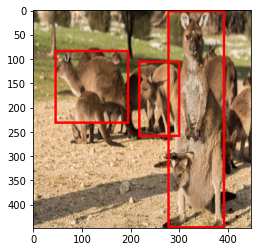

In [8]:
i=0
plot_bounding_box(train_data[i]['image'], train_data[i]['bounding_boxes'])

### Task 2: Create the Target Labels

In [9]:
train_data[95]

{'name': 'kangaroo-303.jpg',
 'original_height': 572,
 'original_width': 1200,
 'bounding_boxes': [90.35, 25.06, 448.0, 426.07],
 'image': array([[[0.38823529, 0.51372549, 0.25882353],
         [0.39607843, 0.52156863, 0.26666667],
         [0.39607843, 0.52156863, 0.26666667],
         ...,
         [0.18039216, 0.24705882, 0.12156863],
         [0.18431373, 0.23529412, 0.13333333],
         [0.18823529, 0.22745098, 0.14901961]],
 
        [[0.38823529, 0.51372549, 0.25882353],
         [0.39215686, 0.51764706, 0.2627451 ],
         [0.39607843, 0.52156863, 0.26666667],
         ...,
         [0.19607843, 0.2627451 , 0.13333333],
         [0.17254902, 0.22352941, 0.12156863],
         [0.18039216, 0.21960784, 0.1372549 ]],
 
        [[0.37647059, 0.50196078, 0.24705882],
         [0.38039216, 0.50588235, 0.24705882],
         [0.38823529, 0.51372549, 0.25882353],
         ...,
         [0.18823529, 0.25490196, 0.12156863],
         [0.17647059, 0.22745098, 0.1254902 ],
         [0.176

In [47]:
def create_label_matrix():
    S=9
    C=1
    target_matrix = []
    for m in range(len(train_data)):
        target_y = np.zeros((S,S,C+5))
        count_bb = int(len(train_data[m]['bb_x_y_h_w'])/4)
        for k in range(count_bb):
            j, i = int(S * train_data[m]['bb_x_y_h_w'][4*k + 0]), int(S * train_data[m]['bb_x_y_h_w'][4*k + 1])
            r_h, r_w =S * train_data[m]['bb_x_y_h_w'][4*k + 2], S * train_data[m]['bb_x_y_h_w'][4*k + 3]
            r_h = float('{:.2f}'.format(r_h))
            r_w = float('{:.2f}'.format(r_w))
            x_cell, y_cell = S * train_data[m]['bb_x_y_h_w'][4*k + 0] - j, S * train_data[m]['bb_x_y_h_w'][4*k + 1] - i

            x_cell = float('{:.2f}'.format(x_cell))
            y_cell = float('{:.2f}'.format(y_cell))

            target_y[i, j, 0] = 1
            target_y[i, j, 1] = 1
            target_y[i, j, 2:7] = x_cell, y_cell, r_h, r_w
        target_matrix.append(target_y)
    return np.array(target_matrix)

In [48]:
target_matrix = create_label_matrix()

In [49]:
len(train_data[7]['bb_x_y_h_w'])/4

8.0

In [50]:
target_matrix.shape

(287, 9, 9, 6)